In [53]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import tqdm.notebook as tqdm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision

from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToPILImage
from IPython.display import Image
from scipy.stats import pearsonr

import copy
import os
import sys
sys.path.append('/Users/Matt/projects/gmmvae/')

import gmmvae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
rawhdata = pd.read_csv('../data/CIFAR10/cifar10h-raw.csv')
hprobs = np.load('../data/CIFAR10/cifar10h-probs.npy')

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.CIFAR10('../data', train=False, download=True, transform=transform)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'house', 'ship', 'truck')

Files already downloaded and verified


In [166]:
class GMMVAEDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, labels, transform=False):
        self.x = x
        self.y = torch.tensor(y)
        self.labels = torch.tensor(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x = self.x[idx, ...]
        y = self.y[idx, ...]
            
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
gmmvae_dataset = GMMVAEDataset(dataset.data, hprobs, dataset.targets, transform)
gmmvae_loader = torch.utils.data.DataLoader(gmmvae_dataset, batch_size=64)

In [211]:
def train_vae(model, loader, optimiser, epoch):
    model.train()
    train_loss = 0
    batch_iter = tqdm.tqdm(enumerate(loader), desc='Batch')
    
    for batch_idx, (x, y) in batch_iter:
        optimiser.zero_grad()
        if type(model) in [gmmvae.models.VAE]:
            loss = -model.elbo(x, num_samples=1)
        else:
            loss = -model.elbo(x, y.float(), num_samples=1)
            
        loss.backward()
        optimiser.step()
        
        train_loss += loss.item()
        batch_iter.set_postfix(loss=loss.item())
        
    print('====> Epoch: {} Average loss: {:.3f}'.format(epoch, train_loss / len(loader.dataset)))

## Construct CIFAR10 VAE.

In [241]:
z_dim = 16

likelihood = gmmvae.templates.CIFAR10Likelihood(z_dim)
likelihood_y = gmmvae.likelihoods.NNCategorical(z_dim, 10, [64, 64])
variational_dist = gmmvae.templates.CIFAR10VariationalDist(z_dim)
variational_dist_y = gmmvae.likelihoods.NNHeteroGaussian(10, z_dim, [64, 64])


# Define various VAE models.
vae = gmmvae.models.VAE(copy.deepcopy(likelihood), copy.deepcopy(variational_dist), z_dim)
gmm_vae = gmmvae.models.GMMVAE(
    copy.deepcopy(likelihood), copy.deepcopy(variational_dist), z_dim, 10)
mmvae = gmmvae.models.MultiModalVAE(
    copy.deepcopy(likelihood), copy.deepcopy(likelihood_y), copy.deepcopy(variational_dist), 
    copy.deepcopy(variational_dist_y), z_dim)

In [210]:
gmmvae_optimiser = optim.Adam(gmm_vae.parameters())
for epoch in range(1, 50):
    train_vae(gmm_vae, gmmvae_loader, gmmvae_optimiser, epoch)

> <ipython-input-208-4028c1d4955c>(13)train_vae()
     11             import pdb
     12             pdb.set_trace()
---> 13             loss = -model.elbo(x, y.float(), num_samples=1)
     14 
     15         loss.backward()

ipdb> q



BdbQuit: 

In [244]:
mmvae_optimiser = optim.Adam(mmvae.parameters())
for epoch in range(1, 50):
    train_vae(mmvae, gmmvae_loader, mmvae_optimiser, epoch)


====> Epoch: 1 Average loss: 66.150



====> Epoch: 2 Average loss: 43.205



====> Epoch: 3 Average loss: 39.137



====> Epoch: 4 Average loss: 35.341



====> Epoch: 5 Average loss: 31.612



====> Epoch: 6 Average loss: 28.002



====> Epoch: 7 Average loss: 24.491



====> Epoch: 8 Average loss: 21.377



====> Epoch: 9 Average loss: 18.357



====> Epoch: 10 Average loss: 16.126



====> Epoch: 11 Average loss: 14.053



====> Epoch: 12 Average loss: 12.231



====> Epoch: 13 Average loss: 11.077



====> Epoch: 14 Average loss: 10.516



====> Epoch: 15 Average loss: 10.142



====> Epoch: 16 Average loss: 9.883



====> Epoch: 17 Average loss: 9.382



====> Epoch: 18 Average loss: 8.905



====> Epoch: 19 Average loss: 8.693



====> Epoch: 20 Average loss: 8.551



====> Epoch: 21 Average loss: 8.327



====> Epoch: 22 Average loss: 8.057



====> Epoch: 23 Average loss: 7.617



====> Epoch: 24 Average loss: 7.348



====> Epoch: 25 Average loss: 7.001



====> Epoch: 26 Average loss: 6.709



====> Epoch: 27 Average loss: 6.549



====> Epoch: 28 Average loss: 6.351



====> Epoch: 29 Average loss: 6.157



====> Epoch: 30 Average loss: 5.854



====> Epoch: 31 Average loss: 5.511



====> Epoch: 32 Average loss: 5.205



====> Epoch: 33 Average loss: 4.980



====> Epoch: 34 Average loss: 4.817



====> Epoch: 35 Average loss: 4.667



====> Epoch: 36 Average loss: 4.526



====> Epoch: 37 Average loss: 4.358



====> Epoch: 38 Average loss: 4.251



====> Epoch: 39 Average loss: 4.190



====> Epoch: 40 Average loss: 4.011



====> Epoch: 41 Average loss: 3.911



====> Epoch: 42 Average loss: 3.789



====> Epoch: 43 Average loss: 3.572



====> Epoch: 44 Average loss: 3.362



====> Epoch: 45 Average loss: 3.289



====> Epoch: 46 Average loss: 3.314



====> Epoch: 47 Average loss: 3.335



====> Epoch: 48 Average loss: 3.315



====> Epoch: 49 Average loss: 3.281


> /Users/Matt/projects/gmmvae/gmmvae/models.py(598)sample()
    596         import pdb
    597         pdb.set_trace()
--> 598         z = qz.sample((num_samples,))
    599         px_z = self.likelihood_x(z)
    600         py_z = self.likelihood_y(z)

ipdb> c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


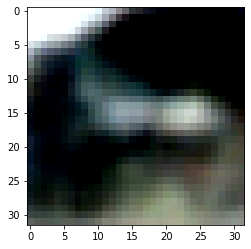

In [247]:
x = transform(dataset.data[np.random.randint(len(dataset))]).unsqueeze(0)
pi = torch.zeros(10)
pi[0] = 1
x_sample, y_sample, px, py = mmvae.sample(y=pi)

x_orig = x
# import pdb
# pdb.set_trace()
x_recon = px.mean.detach()

# x_combined = torchvision.utils.make_grid(torch.cat((x_orig, x_recon)))
x_combined = x_recon.squeeze(0)
# Unnormalise.
x_combined = x_combined / 2 + 0.5

plt.imshow(np.transpose(x_combined, (1, 2, 0)))

In [194]:
gmm_vae.pz_y_logsigma.exp()[:, 5]

tensor([0.9555, 1.3180, 1.1149, 1.4543, 0.8189, 1.4912, 0.8926, 1.4059, 1.0361,
        1.4802], grad_fn=<SelectBackward>)

## Get entropy metric

In [143]:
def distance_from_mean(z, y, mus=None):
    sd = torch.zeros(len(z))

    for k in range(y.max()):
        zk = z[y == k, :]
        
        if mus is None:
            muk = zk.mean(0)
        else:
            muk = mus[k]
            
        sdk = ((zk - muk) ** 2).sum(1)
        sd[y == k] = sdk
        
    return sd

def h_sd_pearsonr(z, h, y, mus=None):
    sd = distance_from_mean(z, y, mus=None)
    
    # Pearson correlation coefficient requires each dataset to be normally distributed.
    h_mu, h_std = h.mean(), h.std()
    sd_mu, sd_std = sd.mean(), sd.std()
    h = (h - h_mu) / h_std
    sd = (sd - sd_mu) / sd_std
    
    return pearsonr(h, sd)

In [141]:
x = torch.zeros((10000, 3, 32, 32))
for i in range(len(dataset.data)):
    x[i, ...] = transform(dataset.data[i])

y = np.array(dataset.targets)

h = torch.zeros(len(hprobs))
for i in range(len(hprobs)):
    prob = hprobs[i][np.nonzero(hprobs[i])]
    h[i] = - (prob * np.log(prob) / np.log(2)).sum()
    
qz = vae.variational_dist(x)
z = qz.mean.detach()

In [145]:
h_sd_pearsonr(z, h, y, mus=None)

(-0.003950985577606012, 0.6928054645775263)